# Behavioral Cloning
processing flow:
1. data preprocessing
2. data augmented
3. building model
4. training phase
5. testing phase

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import os

### Configuration

In [2]:
w, h, c = 200, 66, 3
config = {
    'input_width': w,
    'input_height': h,
    'input_channels': c,
    'batch_size': 512,
    'delta_correction': 0.25,
    'crop_height': range(20, 140),
    'augmentation_steer_sigma': 0.2,
    'augmentation_value_min': 0.2,
    'augmentation_value_max': 1.5,
    'bias': 0.8,
}

### dataset loaded
Let's parse the annotations and return dataframe width columns including `['front', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']`, and replacing image path with specific path.

In [3]:
def load_dataset_df(dpath):
    head_csv = ['front', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']
    csv_df = pd.read_csv(os.path.join(dpath, 'driving_log.csv'), names=head_csv)
    csv_df['front'] = [os.path.join(dpath, 'IMG', front.split('\\')[-1]) for front in csv_df['front']]
    csv_df['left'] = [os.path.join(dpath, 'IMG', front.split('\\')[-1]) for front in csv_df['left']]
    csv_df['right'] = [os.path.join(dpath, 'IMG', front.split('\\')[-1]) for front in csv_df['right']]
    return csv_df

dpath = os.path.join('data')
ddf = load_dataset_df(dpath)

Let us see the distribution of steering data in each of direction of camera.

In [4]:
def draw_histogram_of_steering_angle(ddf, save=True, filename='steering_angle.jpg'):
    f, ax = plt.subplots(1, 1)
    ax.set_title('Steering Angle Distribution in Fronted Camera')
    fhist = ax.hist(ddf['steer'].values, 100, density=False, facecolor='green', alpha=0.7, width=0.03)
    ax.set_ylabel('frames')
    ax.set_xlabel('steering angle')
    # image saved
    if save:
        if not os.path.exists('output'):
            os.makedirs('output')
        plt.savefig(os.path.join('output', filename))
    plt.show()

In [5]:
import random

def moderate_dataset(ddf):
    count, divs = np.histogram(ddf['steer'], bins=100)
    idx = count.argsort()[::-1][:2]

    f_c = count[idx[0]]
    s_c = count[idx[1]]
    f_v = divs[idx[0]]

    drop_idx = ddf['steer'] == f_v
    drop_idx = ddf['steer'][drop_idx].index
    drop_idx = random.sample(drop_idx, f_c - s_c)
    ddf = ddf.drop(drop_idx)
    return ddf

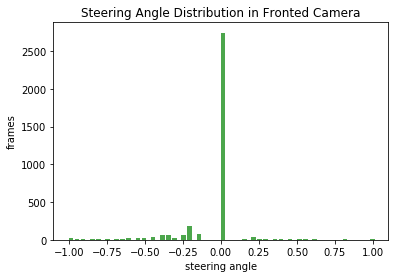

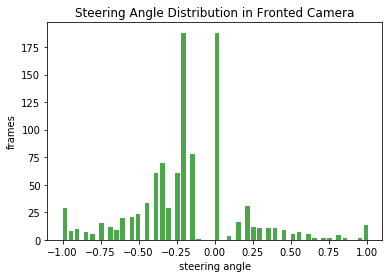

In [6]:
# before mitigate
draw_histogram_of_steering_angle(ddf)
# after
ddf = moderate_dataset(ddf)
draw_histogram_of_steering_angle(ddf, True, filename='steering_angle_m.jpg')

### 1. Data Preprocessing
Choosing randomly among front, left and right mounted camera, each of frames will through several step processed including cropped, color brightness, and flipped.

First at first, transform pandas dataframe into numpy array for future usage.

In [7]:
def pd2np(ddf):
    data = []
    for id, df in ddf.iterrows():
        data.append([df['front'], 
                    df['left'], 
                    df['right'],
                    np.float32(df['steer']),
                    df['throttle'],
                    df['brake'],
                    df['speed']])
    return np.array(data, dtype=np.object)

data = pd2np(ddf)
print(data.shape)

(1016, 7)


Secondly, lets split data into training and testing set

In [8]:
from random import shuffle

def split_train_test(data, ratio=0.8):
    # shuffle
    shuffle(data)
    size = int(data.shape[0]*ratio)
    train = data[0:size]
    test = data[size:]
    return train, test

train, test = split_train_test(data)

Thirdly, cropping and resizing frame.

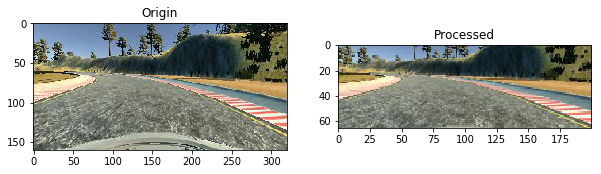

In [9]:
def preprocessing_data(imgp, verbose=False, save=True):
    img = mpimg.imread(imgp)
    cropped = img[config['crop_height'], :, :]
    resized = cv2.resize(cropped, dsize=(w, h))
    # if input_channel equals to 1, changed color space from RGB to YUV
    if config['input_channels'] == 1:
        resized = np.expand_dims(cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)[:, :, 0], 2)
    
    if verbose:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].set_title('Origin')
        ax[0].imshow(img)
        ax[1].set_title('Processed')
        ax[1].imshow(resized)
        if save:
            if not os.path.exists('output'):
                os.makedirs('output')
            plt.savefig(os.path.join('output', 'preprocessing.jpg'))
        plt.show()
        
    return resized.astype(np.float32)

_ = preprocessing_data(train[0, 0], True)

Finally, we generate batch of training data augmentated.

In [10]:
import random

def generate_batch(data, batch_size=128, augmented=True, bias=0.5):
    while True:
        shuffle(data)
        n_current = 0
        X = np.zeros(shape=(batch_size, h, w, c,), dtype=np.float32)
        y_steer = np.zeros(shape=(batch_size,), dtype=np.float32)
        
        for d in data:
            if n_current == batch_size:
                break
            # choose frame randomly among (front, left, right)
            cameraid = random.randint(0, 2)
            frame = preprocessing_data(d[cameraid])
            if cameraid == 0:
                steer = d[3]
            elif cameraid == 1:
                steer = d[3] + config['delta_correction']
            else:
                steer = d[3] - config['delta_correction']

            if augmented:
                # horizontal flipping
                if random.choice([True, False]):
                    frame = frame[:, ::-1, :]
                    steer *= -1.
                
                # perturb slightly steering angle
                steer += np.random.normal(loc=0, scale=config['augmentation_steer_sigma'])
                
                # if colorful image randomly change brightness
                if config['input_channels'] == 3:
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
                    frame[:, :, 2] *= random.uniform(config['augmentation_value_min'], config['augmentation_value_max'])
                    frame[:, :, 2] = np.clip(frame[:, :, 2], a_min=0, a_max=255)
                    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
                
            # whether steer angle matchs the condition
            steer_magnitude_thresh = np.random.rand()
            if (abs(steer) + bias) < steer_magnitude_thresh:
                pass
            else:
                X[n_current] = frame
                y_steer[n_current] = steer
                n_current += 1
                
        yield X, y_steer

### (Optional) Demonstrate generating batch data
Let's see the batching data looks like.

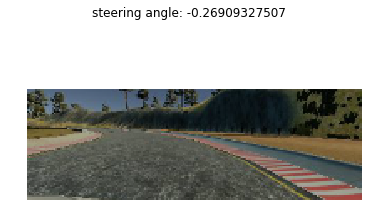

In [11]:
# just a sample data picked up from batch
g = generate_batch(train, batch_size=config['batch_size'])
x, y = next(g)
plt.suptitle('steering angle: {}'.format(y[0]) )
plt.imshow(np.uint8(x[0]))
plt.axis('off')
if not os.path.exists('output'):
    os.makedirs('output')
plt.savefig(os.path.join('output', 'batch.jpg'))
plt.show()

### Build Model

In [12]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Dropout, Flatten, ELU, Lambda, Dense

def E2EModel(verbose=True):
    inputs = Input(shape=(h, w, c))
    # standardize input that applied here is to be accelerated via GPU processing.
    _ = Lambda(lambda z: z/127.5 - 1.)(inputs)
    
    _ = Conv2D(24, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu')(_)
    _ = Conv2D(36, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu')(_)
    _ = Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu')(_)
    _ = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(_)
    _ = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')(_)

    _ = Flatten()(_)
    _ = Dense(100, activation='relu')(_)
    _ = Dense(50, activation='relu')(_)
    _ = Dense(10, activation='relu')(_)
    
    outputs = Dense(1, activation='tanh')(_)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    if verbose:
        model.summary()
        
    return model

Using TensorFlow backend.


In [13]:
model = E2EModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
__________

### Training

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras.backend as K
from keras.optimizers import Adam

epochs = 500
steps_per_epoch = config['batch_size']
validation_steps = config['batch_size']
lr = 1e-3

optimizer = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimizer)

if not os.path.exists('weights'):
    os.makedirs('weights')
checkpoint_callback = ModelCheckpoint(os.path.join('weights', 'w.{epoch:02d}-{val_loss:.5f}.hd5'))
logger = CSVLogger(filename='history.csv')

model.fit_generator(generator=generate_batch(train, batch_size=config['batch_size'], bias=config['bias']),
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs,
                    validation_data=generate_batch(test, batch_size=config['batch_size'], bias=1.0),
                    validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, logger])

In [ ]:
g = generate_batch(test, batch_size=1)
x, y = next(g)
py = model.predict(x)
print(py)
print(y)